#### Weekly Dataset

Each week, I'm dedicating myself to exploring, modeling, and doing stuff with a dataset. Trying to master different modalities and such while reviewing different statistical tests I don't use as often as I should.

This week, I'll hit on something vital to NLP today: embeddings.

# Text Searching...With Vectors!

Vector databases seem to be all the rage now. From my understanding, it seems like like all they are is embedding text using a transformer model and doing a similarity search sprinkled with database stuff like quick queries and insertions. However, we do have old school ways to look up text that has been numberified, though not as optimized.

So in this piece, we'll walk through using the wonderful <a href="https://www.kaggle.com/competitions/learn-ai-bbc/data?select=BBC+News+Train.csv">BBC new dataset</a> to embed text in various ways, and then we'll do a search for similar articles, not based on keywords but rather based on these vector embeddings. Ok, let's start.

## Loading in our Data

The BBC dataset simply has two columns: article categoryarticle category and article text. Originally, this data was used in a competition to classify articles, however, we got text which is all we need. We could verify our recommendations with the category label as well. That's a good proxy for article similarity.

First though, pd.read_csv like usual.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pathlib import Path

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# doing this in kaggle, so content is there
# feel free to download and change this to your dir
dir_path = Path("/kaggle/input/bbc-fulltext-and-category")

In [3]:
df = pd.read_csv(dir_path / "bbc-text.csv")

In [4]:
# seems legit
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
# pretty small. Only 2225 rows. Nothing compared to today's data size
# no nulls either. Yay!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


<Axes: xlabel='text', ylabel='Count'>

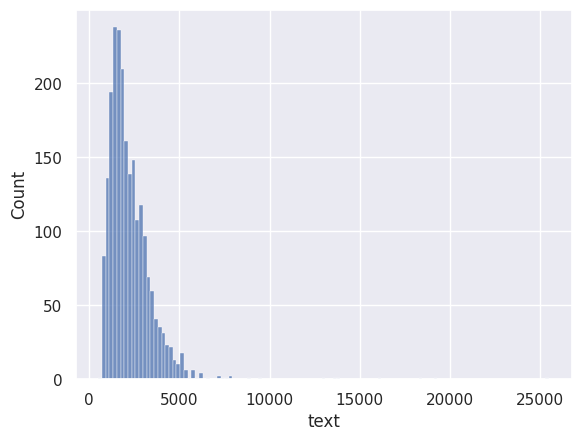

In [6]:
# most articles seem to sit in the 2000-3000 character length
# maybe we should just make this a column in our dataframe and do some
# more stats on it
sns.histplot(df["text"].apply(len))

In [7]:
# bring in regex to help
import re

In [8]:
df["chars"] = df["text"].apply(len)

# remove non-alphanumeric chars, split by whitespace, and count words
df["words"] = df["text"].apply(
    lambda x: len(re.sub(r"[^a-z0-9]", "", x, re.IGNORECASE).split()))

In [9]:
df.describe()

,chars,words
count,2225.00000,2225.000000
mean,2262.93618,388.442697
std,1364.10253,241.767598
min,501.00000,88.000000
25%,1446.00000,248.000000
50%,1965.00000,335.000000
75%,2802.00000,477.000000
max,25483.00000,4490.000000


<Axes: xlabel='words', ylabel='Count'>

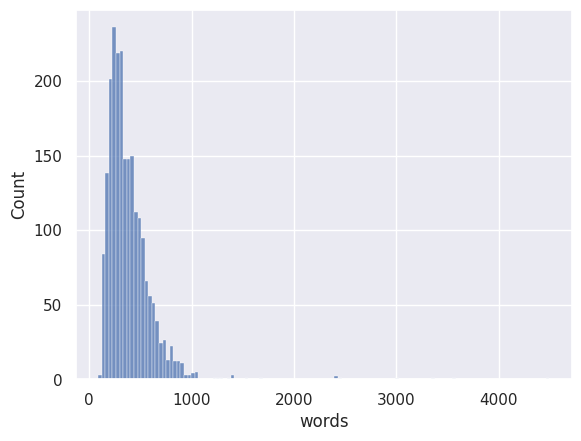

In [10]:
# sameish distribution for words as chars. Our embeddings need, on average 383
# word context length if we tokenize via whitespace. That's about right for
# transformers these days.
sns.histplot(df["words"])

In [11]:
# average word count is ~388. Most transformer models can at least 512 tokens
# we're good when we move to more advanced embeddings
df["words"].describe()

count    2225.000000
mean      388.442697
std       241.767598
min        88.000000
25%       248.000000
50%       335.000000
75%       477.000000
max      4490.000000
Name: words, dtype: float64

In [12]:
df["category"].value_counts().sort_values(ascending=False)

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [13]:
# fairly uniform distribution for categories
df["category"].value_counts().sort_values(ascending=False) / df.shape[0]

category
sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: count, dtype: float64

In [14]:
df["category"].value_counts().sort_values(ascending=False) / df.shape[0]

category
sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: count, dtype: float64

<Axes: xlabel='category', ylabel='count'>

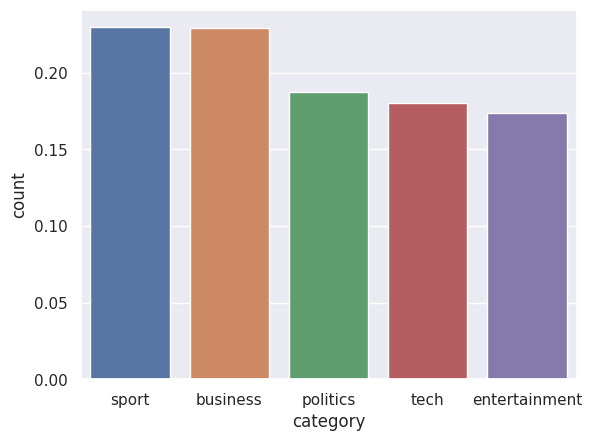

In [15]:
sns.barplot((df["category"].value_counts().sort_values(ascending=False) / df.shape[0]).to_frame().reset_index(),
            x="category", 
            y="count")

Looking at these data, we have a fairly uniform distribution of categories (no outlier categories that might cause issue to stand out), relatively small amount of data, and our average context seems to fit into what transformers can do now-a-days.

First though, let's try old fashion embedding techniques.

## Old School: Embeddings on Counts and Frequencies

Before the days of transformers, we had count and TFIDF vectorizers. The count vectorizer is simple: for each document (in our case article) count the times a word appears in that article. So if we have the sentence: "I love ice cream because I love candy" becomes [2, 2, 1, 1, 1, 1]. The twos represent "I" and "love" and the ones represent all the other words in the sentence. Of course, you need to keep the order the same for each word in each document, meaning slot one represents the same word for each vector.

Easy....but TFIDF is more complicated. It's a combination between two different formulas:

Term Frequency:

\begin{align}
TF(term, document) = \frac{\text{# of times a term appears in a document}}{\text{total # of terms in a document}}
\end{align}

Inverse Document Frequency:

\begin{align}
IDF(term, corpus) = log(\frac{\text{Number of total documents}}{\text{number of documents that contains a term}})
\end{align}

Giving us overall:

\begin{align}
TFIDF = TF * IDF
\end{align}

What's this mean? Well TF means the percentage of a document that's made up of a specific word. IDF is the log of the the number of overall documents divided by the times a term appears in a document.

For example, if the "basketball" appears 10 in an article that is 300 words long, the TF equals 10 /300 = 1/30. Easy enough. Now let's say there are 1000 documents, and basketball appears in only 2 of them. We get the IDF to be log(1000/2) = log(500) ~ 2.7.

So what?

Well TF gets bigger the more a word appears in a document. This is sorta like simple counts but with percentages instead. IDF is high if a word is rare i.e. it appears in only a few of the overall documents, and it can be close to zero if it appears in a lot of document or all documents.

It's like a multiplcation of rarity in document and rarity overall across the corpus. If it's a rare word in the entire article space and takes up a lot of words in the document, we want it to be important ie be a big number.

Let's see what the graph looks like:

In [16]:
tf = np.linspace(0, 100, 100)
idf = np.linspace(0, 100, 100)

In [17]:
TF, IDF = np.meshgrid(tf, idf)

In [18]:
# TF-IDF = TF * IDF
TFIDF = TF * IDF

In [19]:
import plotly.graph_objects as go

In [20]:
fig = go.Figure(data=[go.Surface(z=TFIDF, x=TF, y=IDF)])

In [21]:
fig.update_layout(title="TFIDF Viz",
                  xaxis_title="X Axis Title",
                  yaxis_title="Y Axis Title",
                  autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
                      xaxis_title="TF",
                      yaxis_title="IDF",
                      zaxis_title="TFIDF",
                      )
                  )
fig.show()

A high TFIDF value means that both a term happens a lot in a specific document and that same term only happens in a few documents. Back to our example of basketball, if basketball only appears in only two documents and it represents 10% of all tokens in a document, we would predict a higher TFIDF score than the word "the", which might appear in every document and take up a high percentage of words in a specific document.

That's why we see a kinda of straight line that falls off if you deviate from it: become less rare overall or less frequent in a document and you lose points.

With that, let's use sklearn's built in functions to build both of these:

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [23]:
# count vectorizer automatically lowercases, removed english stop words (the, a, etc)
# it also counts tokens that are only 2 or more alpha-numeric characters, no
# punctuations.
# We'll use 768 as the feaeture size since that's what transformers generally use.
count_vectorizer = CountVectorizer(max_features=768)

In [24]:
count_embeddings = count_vectorizer.fit_transform(df["text"])

In [25]:
# list out all vocab terms or tokens
for i,term in enumerate(count_vectorizer.get_feature_names_out()):
    print(f"{i+1}.) {term}")

1.) 000
2.) 10
3.) 100
4.) 11
5.) 12
6.) 13
7.) 14
8.) 15
9.) 16
10.) 17
11.) 18
12.) 20
13.) 2001
14.) 2002
15.) 2003
16.) 2004
17.) 2005
18.) 25
19.) 30
20.) 40
21.) 50
22.) able
23.) about
24.) access
25.) according
26.) accused
27.) across
28.) act
29.) action
30.) actor
31.) actress
32.) added
33.) africa
34.) after
35.) again
36.) against
37.) age
38.) ago
39.) agreed
40.) ahead
41.) aid
42.) album
43.) all
44.) allow
45.) almost
46.) already
47.) also
48.) although
49.) always
50.) am
51.) american
52.) among
53.) an
54.) analysts
55.) and
56.) announced
57.) annual
58.) another
59.) anti
60.) any
61.) anything
62.) appeal
63.) apple
64.) are
65.) around
66.) arsenal
67.) as
68.) asked
69.) association
70.) at
71.) attacks
72.) australian
73.) available
74.) award
75.) awards
76.) away
77.) back
78.) band
79.) bank
80.) based
81.) bbc
82.) be
83.) beat
84.) because
85.) become
86.) been
87.) before
88.) behind
89.) being
90.) believe
91.) believes
92.) best
93.) better
94.) betw

In [26]:
count_embeddings.todense()

matrix([[1, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 2, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 4, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Notice the count vectorizer is fairly sparse. It only has integer counts and a lot of zeros in each document.

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=768)

In [28]:
tfidf_embeddings = tfidf_vectorizer.fit_transform(df["text"])

In [29]:
# list out all vocab terms
for i,term in enumerate(tfidf_vectorizer.get_feature_names_out()):
    print(f"{i+1}.) {term}")

1.) 000
2.) 10
3.) 100
4.) 11
5.) 12
6.) 13
7.) 14
8.) 15
9.) 16
10.) 17
11.) 18
12.) 20
13.) 2001
14.) 2002
15.) 2003
16.) 2004
17.) 2005
18.) 25
19.) 30
20.) 40
21.) 50
22.) able
23.) about
24.) access
25.) according
26.) accused
27.) across
28.) act
29.) action
30.) actor
31.) actress
32.) added
33.) africa
34.) after
35.) again
36.) against
37.) age
38.) ago
39.) agreed
40.) ahead
41.) aid
42.) album
43.) all
44.) allow
45.) almost
46.) already
47.) also
48.) although
49.) always
50.) am
51.) american
52.) among
53.) an
54.) analysts
55.) and
56.) announced
57.) annual
58.) another
59.) anti
60.) any
61.) anything
62.) appeal
63.) apple
64.) are
65.) around
66.) arsenal
67.) as
68.) asked
69.) association
70.) at
71.) attacks
72.) australian
73.) available
74.) award
75.) awards
76.) away
77.) back
78.) band
79.) bank
80.) based
81.) bbc
82.) be
83.) beat
84.) because
85.) become
86.) been
87.) before
88.) behind
89.) being
90.) believe
91.) believes
92.) best
93.) better
94.) betw

Notice count and tfidf vectorizer both have the same vocab. That's because it takes the n most common where n = max_features specified.

Now we have embeddings. Cool....so what? Well we need a similarity metric to tell how close two vectors are. Remember, our main goal is to query other news articles to recommend to readers based on the current article.

So, we have a few metrics to choose from:

- Cosine Similarity
- L1 Distance (Manhattan/Taxi Cab distance)
- L2 Distance (Euclidean distance)

For this article, we'll focus on L2 distance which is math in the following form:

\begin{align}
\sum_i{(x^1_i - x^2_i})^2
\end{align}

Where x1 is our query vector (the original article from whine we want to recommend something) and x2 is the answer vector (the article we want to recommend). i being the ith index of each vector respectively.

Luckily, this is easy with the numpy function <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html">norm</a>. Simply subtract one embeddings vector from the other and take the norm along an axis. From there, we argsort and have an ordered list of articles to recommend based on the others.

In [30]:
# make the count vector dense to do numpy stuff on
count_vec = count_embeddings.todense()

In [31]:
def recommend(src_article_idx, k):
  """
  Takes in a source article and returns the top k most relevent articles

  Args:
    src_article (int): index of the article to query on
    k (int): number of relevent documents to return in sorted order

  Returns:
    list[int]: list of revelent documents in order
  """
  return np.argsort(np.linalg.norm(count_vec - count_vec[src_article_idx, :], axis=1))[1:k+1]

In [32]:
# using the first article, we see what the most relvent other articles are
recommend_articles = recommend(0, 5)
recommend_articles

array([2141,  971,  135,  781, 1513])

In [33]:
# original article
df.loc[0, "text"]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [34]:
import pprint

In [35]:
# to make our prints more readable
pp = pprint.PrettyPrinter(indent=4)

In [36]:
for i,(_,row) in enumerate(df.loc[recommend_articles, ["text", "category"]].iterrows()):
    print(row["category"])
    pp.pprint(f'{i+1}.) {row["text"]}')
    print()

tech
('1.) blogs take on the mainstream web logs or blogs are everywhere  with at '
 'least an estimated five million on the web and that number is set to grow.  '
 'these online diaries come in many shapes and styles  ranging from people '
 'willing to sharing their views  pictures and links  to companies interested '
 'in another way of reaching their customers. but this year the focus has been '
 'on blogs which cast a critical eye over news events  often writing about '
 'issues ignored by the big media or offering an eye-witness account of '
 'events. most blogs may have only a small readership  but communication '
 'experts say they have provided an avenue for people to have a say in the '
 'world of politics. the most well-known examples include iraqi salam pax s '
 'accounts of the us-led war  former iranian vice-president mohammad ali '
 'abtahi exclusive insight into the islamic republic s government  and the '
 'highs and lows of the recent us election campaign. there are al

Count vector embeddings don't look too bad. All the articles revolve around tech ideas and have a similar semantic meaning. Articles about Bill Gates at a tech event and a robotic pods don't feel that off from each other.

Great. And that's just counting words. Let's see if TFIDF provides more nuance to the recommendations.

In [37]:
# refactor to add embedding matrix as an argument

def recommend(embeddings, src_article_idx, k):
  """
  Takes in a source article and returns the top k most relevent articles

  Args:
    embeddings (np.array): embedding matrix. Index i,j represents the ith article
      and jth embedding element.
    src_article (int): index of the article to query on
    k (int): number of relevent documents to return in sorted order

  Returns:
    list[int]: list of revelent documents in order
  """
  return np.argsort(np.linalg.norm(embeddings - embeddings[src_article_idx, :], axis=1))[1:k+1]

In [38]:
recommend_articles_tfidf = recommend(tfidf_embeddings.todense(), 0, 5)

In [39]:
recommend_articles_tfidf

array([ 912,  455,  228, 2153, 1453])

In [40]:
# original article
df.loc[0, "text"]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [41]:
for i,(_,row) in enumerate(df.loc[recommend_articles_tfidf, ["text", "category"]].iterrows()):
    print(row["category"])
    pp.pprint(f'{i+1}.) {row["text"]}')
    print()

tech
('1.) confusion over high-definition tv now that a critical mass of people '
 'have embraced digital tv  dvds  and digital video recorders  the next '
 'revolution for tv is being prepared for our sets.  in most corners of tv and '
 'technology industries  high-definition (hdtv) is being heralded as the '
 'biggest thing to happen to the television since colour. hd essentially makes '
 'tv picture quality at least four times better than now. but there is real '
 'concern that people are not getting the right information about hd on the '
 'high street. thousands of flat panel screens - lcds (liquid crystal '
 'displays)  plasma screens  and dlp rear-projection tv sets - have already '
 'been sold as  hd   but are in fact not able to display hd.   the uk is the '
 'largest display market in europe   according to john binks  director of gfk  '
 'which monitors global consumer markets.  but  he added:  of all the flat '
 'panel screens sold  just 1.3% in the uk are capable of getting

Wow. This seems really good. All the articles recommended involve TV, even more specific than just tech.

In fact, this is how <a href="https://github.com/karpathy/arxiv-sanity-preserver/blob/master/analyze.py">Andrei Karpathy</a> ranks papers for <a href="https://arxiv-sanity-lite.com/">Arxiv Sanity</a> abit, in a smarter way. It gets us pretty far for a simple algorithm, it runs fast, and it's easy to understand.

However, we can go deeper. A lot new text system use transformer embeddings to really enhance semantic meaning. Let's see what that can do for us.

## Transformer Embeddings

Ok. Now on to the hot stuff. The transformer embeddings. I'm not going to go into full detail on transformers. For reference, I would recommend <a href="https://jalammar.github.io/illustrated-transformer/">Jay Alammar's wonderful blog post</a> for that.

However at a high level, transformers can embed text like we've seens above (a 768 vector of just numbers) but the transformer does it a bit differently. It takes into account not only what words appeared in the text, but the order of the words, meaning we get more context. TFIDF and Count Vectorizers only care about what words appear in a document (in our case article) forgetting about context like "Oswalt shot JFK" vs "JFK shot Oswalt. Transformers can figure out who shot who. Count Vectorizer and TFIDF only know that two people were involved in a shot. In fact, it wouldn't even know if it was a gunshot or a booster shot.

With the brief intro, let's get to using <a href="https://huggingface.co/">Hugging Face</a>, the default transformers library and only modeling thing you'll need...kinda.

In [42]:
from transformers import AutoModel
from transformers import AutoTokenizer

To start, we need a model. <a href="https://en.wikipedia.org/wiki/BERT_(language_model)">BERT</a> is good and cool and fine for this. It was the start of the transformer pre-training and learning that context we talked about above. Again, I won't go into transformers in depth, but just know we're making the words into numbers and making them figure out how the language and text works.

In [43]:
cp = "bert-base-uncased"

In [44]:
# get model to turn text to numbers and calculate embedding
model = AutoModel.from_pretrained(cp)
tokenizer = AutoTokenizer.from_pretrained(cp)

In [45]:
from tqdm.notebook import tqdm

In [46]:
import torch

In [47]:
# use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [49]:
# not training model so need to save gradients
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [50]:
# using kaggle P100, this is pretty fast. About 1 minute.
embeddings = []

for text in tqdm(df["text"]):

  # make tokens and put them on device
  input_tokens = {k:v.to(device) for k,v in tokenizer(text,
                                                      truncation=True,
                                                      return_tensors="pt").items()}

  # get embeddings from basic BERT model
  text_embedding = model(**input_tokens)\
  .last_hidden_state.detach().cpu().numpy().mean(axis=1)

  # remove unnecessary first dimension
  embeddings.append(text_embedding.squeeze())

  0%|          | 0/2225 [00:00<?, ?it/s]

In [51]:
# make an arrray from embeddings and see we have the right shape
embedding_array = np.array(embeddings)

embedding_array.shape

(2225, 768)

In [52]:
recommended_articles_transformer = recommend(embedding_array, 0, 5)

In [53]:
recommended_articles_transformer

array([ 228,  912, 2153, 1453, 1427])

In [54]:
for i,(_,row) in enumerate(df.loc[recommended_articles_transformer, ["text", "category"]].iterrows()):
    print(row["category"])
    pp.pprint(f'{i+1}.) {row["text"]}')
    print()

tech
('1.) tv s future down the phone line internet tv has been talked about since '
 'the start of the web as we know it now.  but any early attempts to do it - '
 'the uk s home choice started in 1992 - were thwarted by the lack of a fast '
 'network. now that broadband networks are bedding down  and it is becoming '
 'essential for millions  the big telcos are keen to start shooting video down '
 'the line. in the face of competition from cable companies offering net voice '
 'calls  they are keen to be the top iptv dogs. software giant microsoft '
 'thinks iptv - internet protocol tv - is the future of television  and it '
 'sits neatly with its vision of the  connected entertainment experience .  '
 'telcos have been wanting to do video for a long time   ed graczyk  director '
 'of marketing for microsoft iptv  told the bbc news website.  the challenge '
 'has been the broadband network  and the state of technology up until not so '
 'long ago did not add up to a feasible solution

Even better....depending on your definition of better. Seems like we still have all the context we like,

Unfortunately, transformers aren't that clear why they do what they do, unless we try some <a href="https://github.com/hila-chefer/Transformer-Explainability">clever tricks</a> that require a good amount of compute.

But ok, we have some vectors. How do we look them up efficently? Right now, we have to do a norm, a lookup, and sort. That means we have to do a norm on each vector and them pull the top-k elements, looking up each element row by row in our embedding matrix. That seems like a lot of work. What's a better way?

## FAISS

<a href="https://github.com/facebookresearch/faiss/tree/main"><a href="https://github.com/facebookresearch/faiss/tree/main">FAISS</a> stands for Fast AI Similarity Search. It's a state of the art similarity search library. It does some fancy math stuff and smart heuristics (at least from my naive eyes) to fine the best matches. On top of this, it allows you to use the GPU tp speed things up. This allows us to do similarity seaerch much quicker than a for loop.

In [55]:
!pip install faiss-gpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 14.7 MB/s eta 0:00:0000:0100:01


In [56]:
import faiss

In [57]:
res = faiss.StandardGpuResources()

In [58]:
## Using a flat index

index_flat = faiss.IndexFlatL2(768)  # build a flat (CPU) index

# make it a flat GPU index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

In [59]:
gpu_index_flat.add(embedding_array)         # add vectors to the index
print(gpu_index_flat.ntotal)

2225


In [60]:
D, I = gpu_index_flat.search(embedding_array[0, :][None, :], k=6)

In [61]:
I[0, 1:]

array([ 228,  912, 2153, 1453, 1427])

We get the exact same results from our native search. Let's do a timing comparision between these two.

In [62]:
%%timeit
D, I = gpu_index_flat.search(embedding_array[0, :][None, :], k=6)

105 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [63]:
%%timeit
recommend(embedding_array, 0, 5)

2.55 ms ± 94.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


FAISS is much much faster as it should be given it's optimized approach.

Sweet. So the pipeline shall be:

get data -> embed text -> move to FAISS -> search

Easy. We'll wrap it up there for now until another week.